# Trabalho GA - Redes II

#### Desenvolvido por:

- Rafael Hansen Klauck

#### Arquivos

- `Dockerfile`: arquivo de configuração do docker
- `docker-compose.yml`: arquivo de configuração do docker-compose
- `image.png`: imagem da topologia utilizada
- `script.sh`: script para criar os volumes utilizados no docker-compose. Ativa os daemons necessários (ospfd, ripd)

### Como rodar?

1. Instalar o docker
2. Instalar `wireshark` para ter o `tshark` e `capinfos`
3. Rodar o script `script.sh` para criar as os volumes que serão utilizados no `docker-compose`
4. Rodar o comando `docker-compose build` na pasta do projeto
5. Rodar o comando `docker-compose up` na pasta do projeto
6. Caso não tenha realizado a configuração dos protocolos, siga os passos abaixo para configurar o RIP e OSPF

### Protocolo RIP

1. Acesse o container com o comando `docker exec -it router_rip_<x> bash`
2. Acesse o terminal do roteador com o comando `vtysh`
3. Acesse o modo de configuração com o comando `configure terminal`
4. Acesse o modo de configuração do protocolo RIP com o comando `router rip`
5. Adicione as redes que deseja anunciar com o comando `network <ip_da_rede>`
6. Escreva `exit` para sair do modo de configuração do protocolo RIP
7. Escreva `exit` para sair do modo de configuração do roteador
8. Escreva `write` para salvar as configurações
9. Refaça os passos para o próximo roteador

#### Redes de cada roteador

**router_rip_0:**

- network 192.168.1.0/24
- network 192.168.4.0/24

**router_rip_1:**

- network 192.168.1.0/24
- network 192.168.2.0/24

**router_rip_2:**

- network 192.168.2.0/24
- network 192.168.3.0/24

**router_rip_3:**

- network 192.168.3.0/24
- network 192.168.4.0/24

### Protocolo OSPF

1. Acesse o container novamente com o comando `docker exec -it router_ospf_<x> bash`
2. Acesse o terminal do roteador com o comando `vtysh`
3. Acesse o modo de configuração com o comando `configure terminal`
4. Acesse o modo de configuração do protocolo OSPF com o comando `router ospf`
5. Adicione as redes que deseja anunciar com o comando `network <ip_da_rede> <wildcard_mask> area <area_id>`
6. Escreva `exit` para sair do modo de configuração do protocolo OSPF
7. Escreva `exit` para sair do modo de configuração do roteador
8. Escreva `write` para salvar as configurações
9. Refaça os passos para o próximo roteador

#### Redes de cada roteador

**router_ospf_0:**

- network 192.168.5.0/24 area 0
- network 192.168.8.0/24 area 0

**router_ospf_1:**

- network 192.168.5.0/24 area 0
- network 192.168.6.0/24 area 0

**router_ospf_2:**

- network 192.168.6.0/24 area 0
- network 192.168.7.0/24 area 0

**router_ospf_3:**

- network 192.168.7.0/24 area 0
- network 192.168.8.0/24 area 0


### Comparações

In [20]:
import subprocess
import time
import threading
import matplotlib.pyplot as plt
import os
from collections import Counter
import pandas as pd

#### Tabela de Roteamento


In [21]:
def run_ospf_ip_route():  
  return subprocess.check_output([
      "docker", "exec", "router_ospf_0", "vtysh", "-c", "show ip route"
  ]).decode()

def run_rip_ip_route():
  return subprocess.check_output([
      "docker", "exec", "router_rip_0", "vtysh", "-c", "show ip route"
  ]).decode()  

In [22]:
ospf_ip_route = run_ospf_ip_route()
rip_ip_route = run_rip_ip_route()
# Get OSPF and RIP lines
ospf_rows = ospf_ip_route.strip().splitlines()
rip_rows = rip_ip_route.strip().splitlines()

**OSPF Routes**

In [23]:
for row in ospf_rows: 
  print(row)

Codes: K - kernel route, C - connected, S - static, R - RIP,
       O - OSPF, I - IS-IS, B - BGP, E - EIGRP, N - NHRP,
       T - Table, v - VNC, V - VNC-Direct, A - Babel, F - PBR,
       f - OpenFabric,
       > - selected route, * - FIB route, q - queued, r - rejected, b - backup
       t - trapped, o - offload failure

K>* 0.0.0.0/0 [0/0] via 192.168.5.254, eth0, 00:04:36
O   192.168.5.0/24 [110/10] is directly connected, eth0, weight 1, 00:04:36
C>* 192.168.5.0/24 is directly connected, eth0, 00:04:36
O>* 192.168.6.0/24 [110/20] via 192.168.5.2, eth0, weight 1, 00:02:46
O>* 192.168.7.0/24 [110/20] via 192.168.8.2, eth1, weight 1, 00:03:42
O   192.168.8.0/24 [110/10] is directly connected, eth1, weight 1, 00:04:36
C>* 192.168.8.0/24 is directly connected, eth1, 00:04:36


**RIP Routes**

In [24]:
for row in rip_rows:
  print(row)

Codes: K - kernel route, C - connected, S - static, R - RIP,
       O - OSPF, I - IS-IS, B - BGP, E - EIGRP, N - NHRP,
       T - Table, v - VNC, V - VNC-Direct, A - Babel, F - PBR,
       f - OpenFabric,
       > - selected route, * - FIB route, q - queued, r - rejected, b - backup
       t - trapped, o - offload failure

K>* 0.0.0.0/0 [0/0] via 192.168.1.254, eth0, 00:04:36
C>* 192.168.1.0/24 is directly connected, eth0, 00:04:36
R>* 192.168.2.0/24 [120/2] via 192.168.1.2, eth0, weight 1, 00:04:35
R>* 192.168.3.0/24 [120/2] via 192.168.4.2, eth1, weight 1, 00:04:34
C>* 192.168.4.0/24 is directly connected, eth1, 00:04:36


#### Desligando roteador após ping
A ideia é analisar o tempo que o protocolo de roteamento leva para conseguir detectar que o roteador está fora do ar e conseguir redirecionar o tráfego para outro caminho.


In [26]:
def ping_loop(target_ip, origin_container, results, stop_event):
  while not stop_event.is_set():
    try:
      output = subprocess.check_output([
        'docker', 'exec', origin_container, 'ping', '-c', '1', '-W', '1', target_ip
      ], stderr=subprocess.DEVNULL)
      print(output.decode())
      success = True
    except subprocess.CalledProcessError:
      success = False
    timestamp = time.time()
    results.append((timestamp, success))
    time.sleep(0.5)

def measure_with_docker(routing_procol, target_ip, origin_container, container_to_stop, delay_before_stop=5):  
  print(f"Starting ping loop from {origin_container} to {target_ip}... Using {routing_procol}")
  results = []
  stop_event = threading.Event()
  thread = threading.Thread(target=ping_loop, args=(target_ip, origin_container, results, stop_event))
  thread.daemon = True # run in background
  thread.start()
  print(f"Waiting {delay_before_stop}s before shutting router down...")
  time.sleep(delay_before_stop)

  print(f"Stoping container {container_to_stop}...")
  subprocess.run(['docker', 'stop', container_to_stop], stdout=subprocess.DEVNULL)

  print("Waiting ping to work again...")
  stop_at, back_at = None, None
  while True:
    for i in range(1, len(results)):
      previous, current = results[i-1], results[i]
      previous_success, current_success = previous[1], current[1]
      if not stop_at and previous_success and not current_success:
        stop_at = current[0] 
      elif stop_at and not previous_success and current_success:
        back_at = current[0]
        break
    if back_at:
      break
    time.sleep(0.1)
 
  stop_event.set()
  thread.join()
  reconvergence_time = back_at - stop_at
  print(f"{routing_procol} reconvergence time: {reconvergence_time:.2f}s")
  return reconvergence_time


def wait_until_has_route(container, destination_subnet, expected_next_hop):
  print(f"Waiting until {container} has route to {destination_subnet} via {expected_next_hop}...")
  while True:
    try:
      output = subprocess.check_output([
        'docker', 'exec', container,
        'vtysh', '-c', 'show ip route'
      ])
      decoded_output = output.decode()
      if destination_subnet in decoded_output and expected_next_hop in decoded_output:
        print("Route found!")
        break
    except subprocess.CalledProcessError:
      pass
    time.sleep(2)

**OSPF**

In [27]:
total_reconvergence_time = 0
for i in range(3):
  reconvergence_time = measure_with_docker(
    routing_procol="OSPF",
    target_ip="192.168.5.2", 
    origin_container="router_ospf_3",
    container_to_stop="router_ospf_0", 
    delay_before_stop=1
  )
  # Restart the router
  subprocess.run(['docker', 'start', 'router_ospf_0'], stdout=subprocess.DEVNULL)

  time.sleep(5)
  # Wait until the router has a route to the destination subnet
  wait_until_has_route(
    container="router_ospf_3",
    destination_subnet="192.168.5.0/24",
    expected_next_hop="192.168.8.1"
  )
  total_reconvergence_time += reconvergence_time

ospf_avg_reconvergence_time = total_reconvergence_time / 3
print(f"Average OSPF reconvergence time: {ospf_avg_reconvergence_time:.2f}s")

Starting ping loop from router_ospf_3 to 192.168.5.2... Using OSPF
Waiting 1s before shutting router down...
PING 192.168.5.2 (192.168.5.2): 56 data bytes
64 bytes from 192.168.5.2: seq=0 ttl=63 time=0.137 ms

--- 192.168.5.2 ping statistics ---
1 packets transmitted, 1 packets received, 0% packet loss
round-trip min/avg/max = 0.137/0.137/0.137 ms

Stoping container router_ospf_0...
PING 192.168.5.2 (192.168.5.2): 56 data bytes
64 bytes from 192.168.5.2: seq=0 ttl=63 time=0.105 ms

--- 192.168.5.2 ping statistics ---
1 packets transmitted, 1 packets received, 0% packet loss
round-trip min/avg/max = 0.105/0.105/0.105 ms

Waiting ping to work again...
PING 192.168.5.2 (192.168.5.2): 56 data bytes
64 bytes from 192.168.5.2: seq=0 ttl=63 time=0.112 ms

--- 192.168.5.2 ping statistics ---
1 packets transmitted, 1 packets received, 0% packet loss
round-trip min/avg/max = 0.112/0.112/0.112 ms

OSPF reconvergence time: 31.94s
Waiting until router_ospf_3 has route to 192.168.5.0/24 via 192.168.

**RIP**

In [28]:
total_reconvergence_time = 0
for i in range(3):
  reconvergence_time = measure_with_docker(
    routing_procol="RIP",
    target_ip="192.168.1.2", 
    origin_container="router_rip_3",
    container_to_stop="router_rip_0", 
    delay_before_stop=1
  )
  # Restart the router
  subprocess.run(['docker', 'start', 'router_rip_0'], stdout=subprocess.DEVNULL)

  time.sleep(5)
  # Wait until the router has a route to the destination subnet
  wait_until_has_route(
    container="router_rip_3",
    destination_subnet="192.168.1.0/24",
    expected_next_hop="192.168.4.1"
  )
  total_reconvergence_time += reconvergence_time

rip_avg_reconvergence_time = total_reconvergence_time / 3
print(f"Average OSPF reconvergence time: {rip_avg_reconvergence_time:.2f}s")

Starting ping loop from router_rip_3 to 192.168.1.2... Using RIP
Waiting 1s before shutting router down...
PING 192.168.1.2 (192.168.1.2): 56 data bytes
64 bytes from 192.168.1.2: seq=0 ttl=63 time=0.133 ms

--- 192.168.1.2 ping statistics ---
1 packets transmitted, 1 packets received, 0% packet loss
round-trip min/avg/max = 0.133/0.133/0.133 ms

Stoping container router_rip_0...
Waiting ping to work again...
PING 192.168.1.2 (192.168.1.2): 56 data bytes
64 bytes from 192.168.1.2: seq=0 ttl=63 time=0.123 ms

--- 192.168.1.2 ping statistics ---
1 packets transmitted, 1 packets received, 0% packet loss
round-trip min/avg/max = 0.123/0.123/0.123 ms

RIP reconvergence time: 188.22s
Waiting until router_rip_3 has route to 192.168.1.0/24 via 192.168.4.1...
Route found!
Starting ping loop from router_rip_3 to 192.168.1.2... Using RIP
Waiting 1s before shutting router down...
PING 192.168.1.2 (192.168.1.2): 56 data bytes
64 bytes from 192.168.1.2: seq=0 ttl=63 time=0.131 ms

--- 192.168.1.2 pi

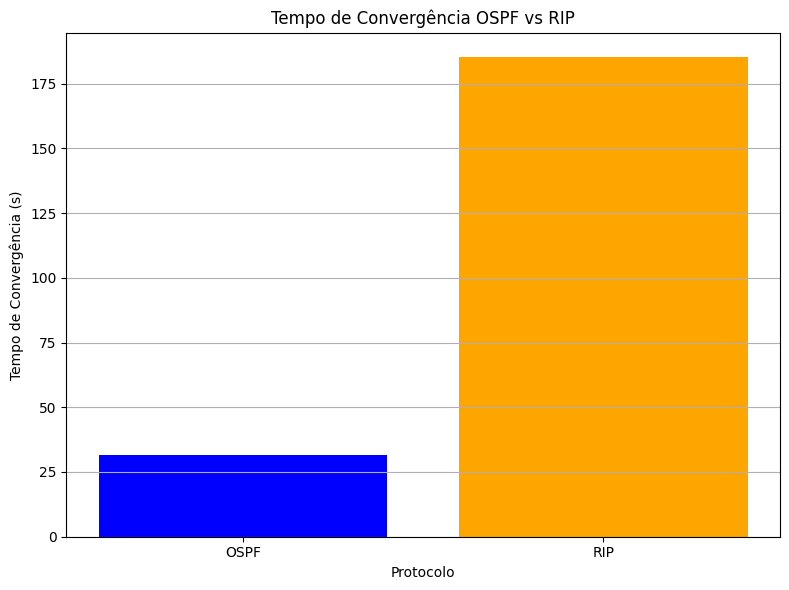

In [29]:
protocols = ['OSPF', 'RIP']

plt.figure(figsize=(8, 6))
plt.bar(protocols, [ospf_avg_reconvergence_time, rip_avg_reconvergence_time], color=['blue', 'orange'])
plt.title('Tempo de Convergência OSPF vs RIP')
plt.ylabel('Tempo de Convergência (s)')
plt.xlabel('Protocolo')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### Capturando pacotes dos protocolos
Para essa análise, foi utilizado o comando `tcpdump` para capturar os pacotes de roteamento que estão sendo enviados na rede. Foi realizado o tcpdump por 1 minuto em cada roteador, e após isso foi feita a análise dos pacotes capturados.



In [30]:
# Create directory to store captures
if not os.path.exists("capturas"):
  os.makedirs("capturas")
capture_duration = 60

def capture_protocol_packets(router_name, protocol, protocol_args, duration = capture_duration):
  filename = f"{router_name}.pcap"
  pcap_file = os.path.join("capturas", filename)
  remote_path = f"/tmp/{filename}"
 
  # delete old pcap file inside container
  subprocess.run(
    ["docker", "exec", router_name, "rm", "-f", remote_path],
    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
  )

  # run tcpdump inside the container
  cmd = [
    "docker", "exec", router_name,
    "sh", "-c",
    f"timeout {duration} tcpdump -i eth0 -s 0 {' '.join(protocol_args)} -w {remote_path}"
  ]

  print(f"Capturing {protocol} packets on {router_name} for {duration}s...")
  subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

  # wait for the capture to finish
  time.sleep(1)

  # copy the pcap file from the container to the host
  subprocess.run(
    ["docker", "cp", f"{router_name}:{remote_path}", pcap_file],
    stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
  )

  return pcap_file

Código para contar a quantidade de pacotes de cada protocolo e extrair os pacotes para um arquivo .pcap


In [31]:
def count_packets(pcap_file):
  output = subprocess.check_output(["capinfos", "-c", pcap_file]).decode()
  lines = output.strip().splitlines()
  for line in lines:
    if "Number of packets" in line:
      packet_count = int(line.split(":")[1].strip())
      return packet_count
  return 0

def count_packets_sizes(pcap_file):
  output = subprocess.check_output(["capinfos", "-d", pcap_file]).decode()
  lines = output.strip().splitlines()
  for line in lines:
    if "Data size" in line:
      size_str = line.split(":")[1].strip().split(" ")[0]
      size_str = size_str.replace(".", "") 
      return int(size_str)
  return 0

def extract_data_byte_rate(pcap_file):
  output = subprocess.check_output(["capinfos", "-b", pcap_file]).decode()
  for line in output.splitlines():
    if "Data byte rate" in line:
      value_str = line.split(":")[1].strip().split(" ")[0]
      return float(value_str) 
  return 0.0

def extract_packet_fields(pcap_file):
  fields = ["ip.src", "ip.dst", "_ws.col.Protocol", "frame.len", "_ws.col.Info"]
  cmd = ["tshark", "-r", pcap_file, "-T", "fields"] + sum([["-e", f] for f in fields], [])
  output = subprocess.check_output(cmd).decode()
  lines = output.strip().splitlines()
  return [line.split('\t') for line in lines if line.strip()]
   

In [32]:
routers = [
  "router_ospf_0", "router_ospf_1", "router_ospf_2", "router_ospf_3",
  "router_rip_0", "router_rip_1", "router_rip_2", "router_rip_3"
]
routers_by_protocol = {
  "RIP": ["router_rip_0", "router_rip_1", "router_rip_2", "router_rip_3"],
  "OSPF": ["router_ospf_0", "router_ospf_1", "router_ospf_2", "router_ospf_3"]
}
protocols = {
  "RIP": ["udp", "port", "520"],
  "OSPF": ["proto", "ospf"]
}

# Clear previous captures
for router in routers:
  pcap_file = os.path.join("capturas", f"{router}.pcap")
  if os.path.exists(pcap_file):
    os.remove(pcap_file)
  print(f"Removed previous capture file: {pcap_file}")

results_by_router = {router: {"RIP": 0, "OSPF": 0} for router in routers}
results_by_protocol = {"RIP": 0, "OSPF": 0}
info_counter = Counter()
info_by_router = {}
router_ospf_3_size = None
router_rip_3_size = None
router_ospf_3_data_rate = None
router_rip_3_data_rate = None

lock = threading.Lock()

def process_router(router, proto_name, filter_args):
  pcap_file = capture_protocol_packets(router, proto_name, filter_args)
  count = count_packets(pcap_file)
  if proto_name == "OSPF" and router == "router_ospf_3":
    global router_ospf_3_size
    global router_ospf_3_data_rate
    router_ospf_3_size = count_packets_sizes(pcap_file)
    router_ospf_3_data_rate = extract_data_byte_rate(pcap_file)
  if proto_name == "RIP" and router == "router_rip_3":
    global router_rip_3_size
    global router_rip_3_data_rate
    router_rip_3_size = count_packets_sizes(pcap_file)
    router_rip_3_data_rate = extract_data_byte_rate(pcap_file)
  
  with lock:
    results_by_router[router][proto_name] = count
    results_by_protocol[proto_name] += count

  rows = extract_packet_fields(pcap_file)

  with lock:
    info_by_router[router] = rows
    for row in rows:
      if len(row) >= 5 and row[4]:
        info_counter[row[4]] += 1


threads = []

for proto_name, filter_args in protocols.items():
  for router in routers_by_protocol[proto_name]:
    thread = threading.Thread(target=process_router, args=(router, proto_name, filter_args))
    threads.append(thread)
    thread.start()

# Wait for all threads to finish
for thread in threads:
  thread.join()



Removed previous capture file: capturas/router_ospf_0.pcap
Removed previous capture file: capturas/router_ospf_1.pcap
Removed previous capture file: capturas/router_ospf_2.pcap
Removed previous capture file: capturas/router_ospf_3.pcap
Removed previous capture file: capturas/router_rip_0.pcap
Removed previous capture file: capturas/router_rip_1.pcap
Removed previous capture file: capturas/router_rip_2.pcap
Removed previous capture file: capturas/router_rip_3.pcap
Capturing RIP packets on router_rip_0 for 60s...
Capturing RIP packets on router_rip_1 for 60s...
Capturing RIP packets on router_rip_2 for 60s...
Capturing OSPF packets on router_ospf_1 for 60s...
Capturing RIP packets on router_rip_3 for 60s...
Capturing OSPF packets on router_ospf_0 for 60s...
Capturing OSPF packets on router_ospf_3 for 60s...
Capturing OSPF packets on router_ospf_2 for 60s...


#### Quantidade de pacotes

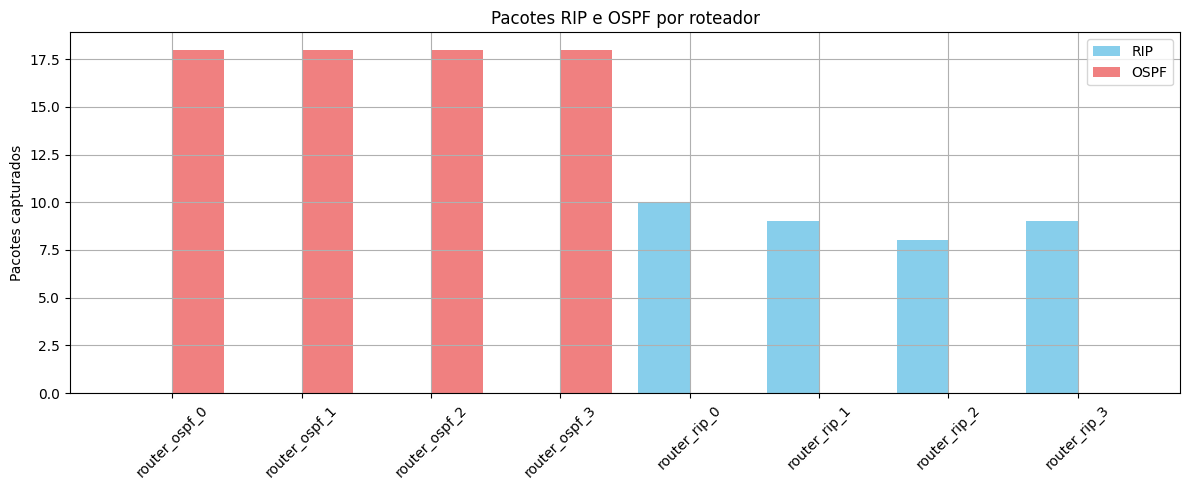

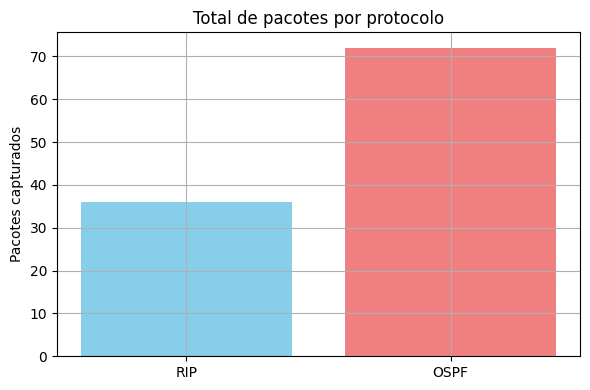

In [33]:
routers_labels = list(results_by_router.keys())
rip_counts = [results_by_router[r]["RIP"] for r in routers_labels]
ospf_counts = [results_by_router[r]["OSPF"] for r in routers_labels]

x = range(len(routers_labels))
bar_width = 0.4

plt.figure(figsize=(12, 5))
plt.bar([i - bar_width/2 for i in x], rip_counts, width=bar_width, label='RIP', color='skyblue')
plt.bar([i + bar_width/2 for i in x], ospf_counts, width=bar_width, label='OSPF', color='lightcoral')

plt.xticks(x, routers_labels, rotation=45)
plt.ylabel("Pacotes capturados")
plt.title("Pacotes RIP e OSPF por roteador")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


plt.figure(figsize=(6, 4))
plt.bar(results_by_protocol.keys(), results_by_protocol.values(), color=["skyblue", "lightcoral"])
plt.title("Total de pacotes por protocolo")
plt.ylabel("Pacotes capturados")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Pacotes Capturados

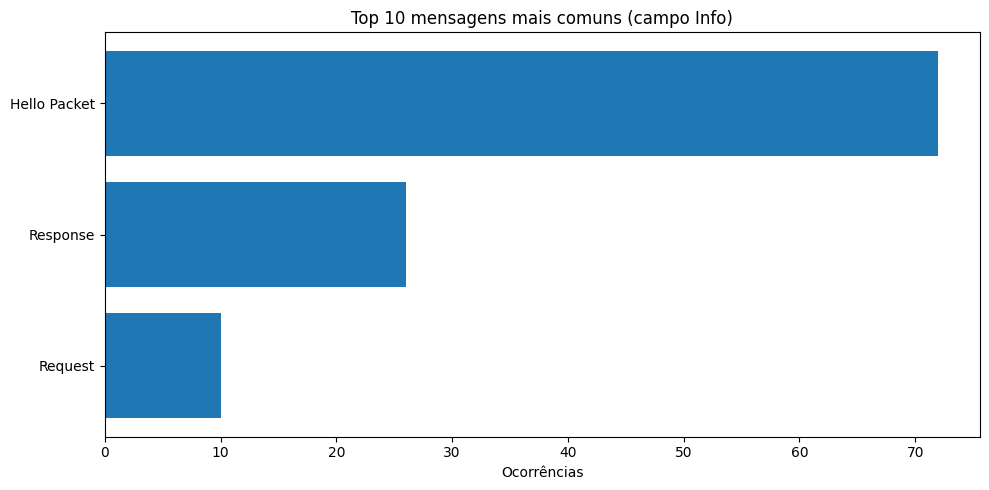


====== ROUTER_RIP_3 ======
        source  destination protocol length      info
0  192.168.3.2    224.0.0.9    RIPv2     66   Request
1  192.168.3.2    224.0.0.9    RIPv2     66   Request
2  192.168.3.1  192.168.3.2    RIPv2     86  Response
3  192.168.3.2    224.0.0.9    RIPv2     86  Response
4  192.168.3.2    224.0.0.9    RIPv2     86  Response
5  192.168.3.1    224.0.0.9    RIPv2     86  Response
6  192.168.3.2    224.0.0.9    RIPv2     86  Response
7  192.168.3.2    224.0.0.9    RIPv2     86  Response
8  192.168.3.1    224.0.0.9    RIPv2     86  Response

====== ROUTER_RIP_1 ======
        source  destination protocol length      info
0  192.168.1.2    224.0.0.9    RIPv2     66   Request
1  192.168.1.2    224.0.0.9    RIPv2     66   Request
2  192.168.1.1  192.168.1.2    RIPv2     86  Response
3  192.168.1.1    224.0.0.9    RIPv2     66   Request
4  192.168.1.2  192.168.1.1    RIPv2     86  Response
5  192.168.1.1    224.0.0.9    RIPv2     86  Response
6  192.168.1.2    224.0.0.

In [34]:
top_infos = info_counter.most_common(10)
labels_info = [i[0] for i in top_infos]
values_info = [i[1] for i in top_infos]

plt.figure(figsize=(10, 5))
plt.barh(labels_info, values_info)
plt.xlabel("Ocorrências")
plt.title("Top 10 mensagens mais comuns (campo Info)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


for router, rows in info_by_router.items():
    df = pd.DataFrame(rows, columns=["source", "destination", "protocol", "length", "info"])
    print(f"\n====== {router.upper()} ======")
    print(df.head(10))

**Mesmo exemplo, porém agora desligando um roteador para ver como o protocolo se comporta**

Removed previous capture file: capturas/router_ospf_3.pcap
Capturing OSPF packets on router_ospf_3 for 60s...
Stopping OSPF router...
Starting OSPF router...


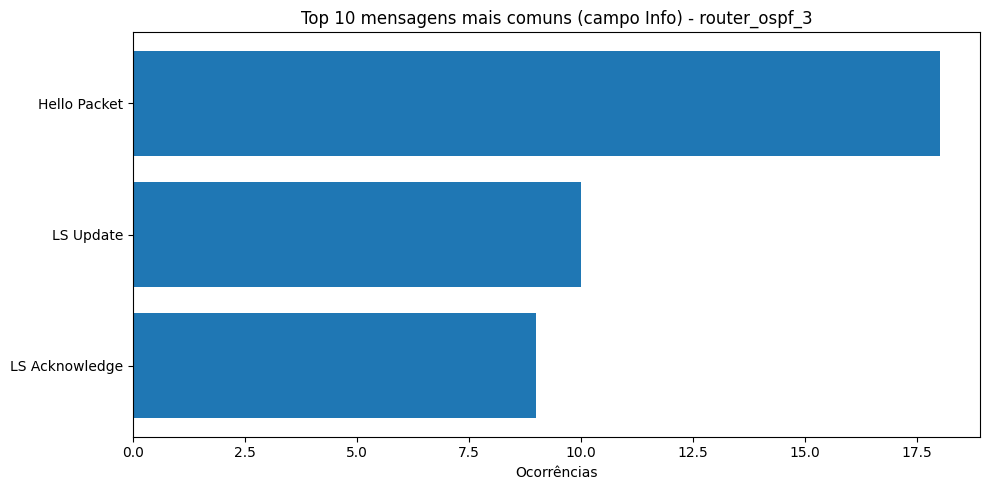


====== router_ospf_3 ======
         source destination protocol length            info
0   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
1   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
2   192.168.7.1   224.0.0.5     OSPF     82    Hello Packet
3   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
4   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
5   192.168.7.1   224.0.0.5     OSPF     82    Hello Packet
6   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
7   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
8   192.168.7.1   224.0.0.5     OSPF     82    Hello Packet
9   192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
10  192.168.7.2   224.0.0.5     OSPF     82    Hello Packet
11  192.168.7.2   224.0.0.5     OSPF    142       LS Update
12  192.168.7.2   224.0.0.5     OSPF    142       LS Update
13  192.168.7.1   224.0.0.5     OSPF    142       LS Update
14  192.168.7.2   224.0.0.5     OSPF     98  LS Acknowledge
15  192.168

In [35]:
router_ospf_3_pcap_file = os.path.join("capturas", "router_ospf_3.pcap")

if os.path.exists(router_ospf_3_pcap_file):
  os.remove(router_ospf_3_pcap_file)
  print(f"Removed previous capture file: {router_ospf_3_pcap_file}")


def run_capture_thread(router, protocol, protocol_args, duration):
  capture_protocol_packets(router, protocol, protocol_args, duration)

# Start the capture thread for OSPF
thread = threading.Thread(target=run_capture_thread, args=("router_ospf_3", "OSPF", ["proto", "ospf"], 60))
thread.start()

# Wait for the capture to finish
time.sleep(10)
print("Stopping OSPF router...")
subprocess.run(["docker", "stop", "router_ospf_0"], stdout=subprocess.DEVNULL)
time.sleep(20)
print("Starting OSPF router...")
subprocess.run(["docker", "start", "router_ospf_0"], stdout=subprocess.DEVNULL)
thread.join()
rows = extract_packet_fields(router_ospf_3_pcap_file)
router_ospf_3_size_after_turning_off = count_packets_sizes(router_ospf_3_pcap_file)
router_ospf_3_data_rate_after_turning_off = extract_data_byte_rate(router_ospf_3_pcap_file)

df = pd.DataFrame(rows, columns=["source", "destination", "protocol", "length", "info"])
info_counter = Counter(df["info"].dropna())
top_infos = info_counter.most_common(10)
labels_info = [i[0] for i in top_infos]
values_info = [i[1] for i in top_infos]
plt.figure(figsize=(10, 5))
plt.barh(labels_info, values_info)
plt.xlabel("Ocorrências")
plt.title("Top 10 mensagens mais comuns (campo Info) - router_ospf_3")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n====== router_ospf_3 ======")
print(df.head(20))


Removed previous capture file: capturas/router_rip_3.pcap
Capturing RIP packets on router_rip_3 for 60s...
Stopping RIP router...
Starting RIP router...


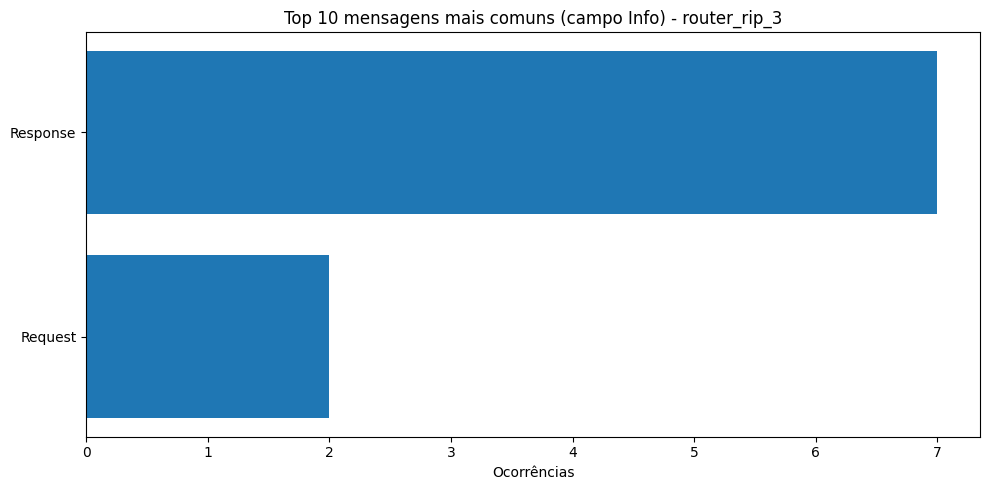


====== router_rip_3 ======
        source  destination protocol length      info
0  192.168.3.2    224.0.0.9    RIPv2     66   Request
1  192.168.3.2    224.0.0.9    RIPv2     66   Request
2  192.168.3.1  192.168.3.2    RIPv2     86  Response
3  192.168.3.2    224.0.0.9    RIPv2     86  Response
4  192.168.3.2    224.0.0.9    RIPv2     86  Response
5  192.168.3.1    224.0.0.9    RIPv2     86  Response
6  192.168.3.2    224.0.0.9    RIPv2     86  Response
7  192.168.3.2    224.0.0.9    RIPv2     86  Response
8  192.168.3.1    224.0.0.9    RIPv2     86  Response


In [36]:
router_ospf_3_pcap_file = os.path.join("capturas", "router_rip_3.pcap")

if os.path.exists(router_ospf_3_pcap_file):
  os.remove(router_ospf_3_pcap_file)
  print(f"Removed previous capture file: {router_ospf_3_pcap_file}")


def run_capture_thread(router, protocol, protocol_args, duration):
  capture_protocol_packets(router, protocol, protocol_args, duration)

# Start the capture thread for RIP
thread = threading.Thread(target=run_capture_thread, args=("router_rip_3", "RIP", ["udp", "port", "520"], 60))
thread.start()

# Wait for the capture to finish
time.sleep(10)
print("Stopping RIP router...")
subprocess.run(["docker", "stop", "router_rip_0"], stdout=subprocess.DEVNULL)
time.sleep(20)
print("Starting RIP router...")
subprocess.run(["docker", "start", "router_rip_0"], stdout=subprocess.DEVNULL)
thread.join()
rows = extract_packet_fields(router_ospf_3_pcap_file)
router_rip_3_size_after_turning_off = count_packets_sizes(router_ospf_3_pcap_file)
router_rip_3_data_rate_after_turning_off = extract_data_byte_rate(router_ospf_3_pcap_file)

df = pd.DataFrame(rows, columns=["source", "destination", "protocol", "length", "info"])
info_counter = Counter(df["info"].dropna())
top_infos = info_counter.most_common(10)
labels_info = [i[0] for i in top_infos]
values_info = [i[1] for i in top_infos]
plt.figure(figsize=(10, 5))
plt.barh(labels_info, values_info)
plt.xlabel("Ocorrências")
plt.title("Top 10 mensagens mais comuns (campo Info) - router_rip_3")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n====== router_rip_3 ======")
print(df.head(20))


**Tráfego em bytes gerado pelos protocolos**

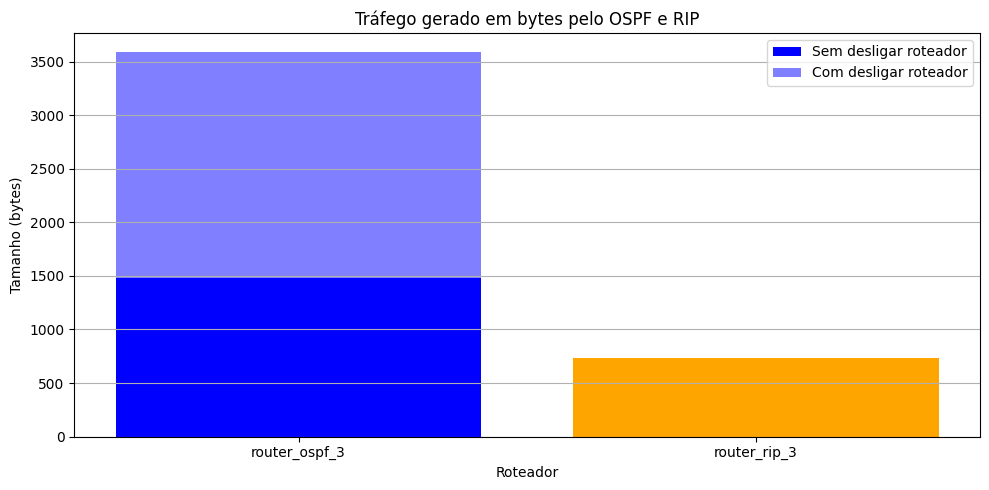

In [40]:
# Chart with the packet sizes before and after turning off the router
plt.figure(figsize=(10, 5))
plt.bar(["router_ospf_3", "router_rip_3"], [router_ospf_3_size, router_rip_3_size], color=["blue", "orange"], label="Sem desligar roteador")
plt.bar(["router_ospf_3", "router_rip_3"], [router_ospf_3_size_after_turning_off, router_rip_3_size_after_turning_off], color=["blue", "orange"], alpha=0.5, label="Com desligar roteador")
plt.title("Tráfego gerado em bytes pelo OSPF e RIP")
plt.ylabel("Tamanho (bytes)")
plt.xlabel("Roteador")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Taxa de transmissão dos protocolos**

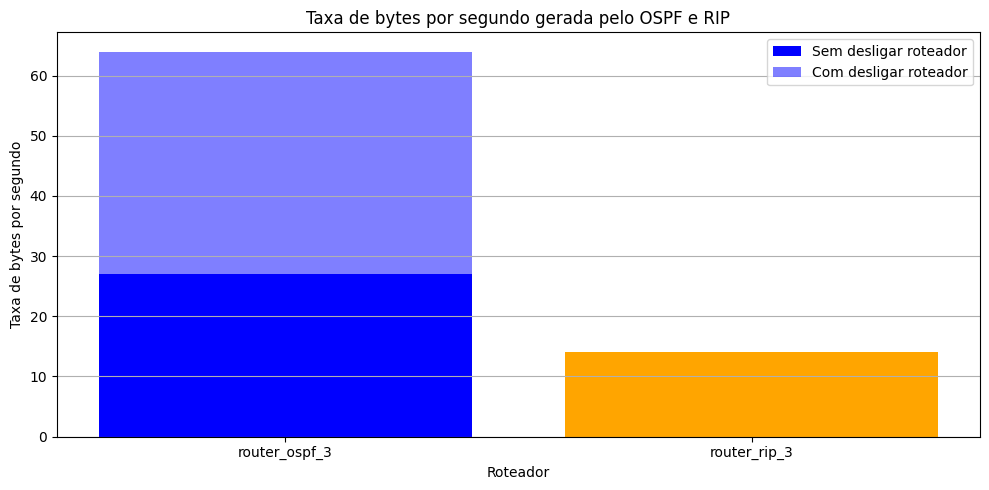

In [39]:
plt.figure(figsize=(10, 5))
plt.bar(["router_ospf_3", "router_rip_3"], [router_ospf_3_data_rate, router_rip_3_data_rate], color=["blue", "orange"], label="Sem desligar roteador")
plt.bar(["router_ospf_3", "router_rip_3"], [router_ospf_3_data_rate_after_turning_off, router_rip_3_data_rate_after_turning_off], color=["blue", "orange"], alpha=0.5, label="Com desligar roteador")
plt.title("Taxa de bytes por segundo gerada pelo OSPF e RIP")
plt.ylabel("Taxa de bytes por segundo")
plt.xlabel("Roteador")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Conclusões
- O OSPF convergiu mais rápido que o RIP, o que é esperado, já que o OSPF é um protocolo de roteamento mais avançado e eficiente.
- OSPF gerou mais pacotes do que o RIP, o que é esperado, já que o OSPF envia pacotes de atualização de roteamento com mais frequência.
- O tráfego total em bytes capturado nos roteadores OSPF foi bem maior do que nos roteadores RIP, tanto antes quanto após a convergência.